# Ames Housing Project - Regression Models and Model Stacking

### Purpose of Project 

This project uses a database of housing sales data from Ames, Iowa (go Cyclones!) from 2006 to 2010. The purpose of the project was to predict house sales using a variety of features related to the quality and physical attributes of the house. The project used a Kaggle competition site, so you will see I do train-holdout splits on the train dataset.  I only show the holdout set scores in this notebook. 

In this notebook, I try out a few regression models to predict housing price. 

1) Top-Down approach, where I choose features based on a .50 correlation or greater with the target variable, Sale Price. R-squared for this model was .89. 

2) "Everything Including the Kitchen Sink," where I use all variables and put them through a linear regressino with Lasso Regularization. This was the best performing model, with an R-squared of .96.  

3) Model stacking. I use several different regression models together and achieve an R-squared of .92.  

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, Imputer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor

In [2]:
train = pd.read_csv('./train_for_reg_and_class.csv')

In [3]:
test = pd.read_csv('./test_for_reg_and_class.csv')

In [5]:
test.shape

(879, 286)

## Model 1: Basic Linear Regression with Top-Down Approach
I'll look at correlations the features and the target, Sale Price, and pick the ones with the highest correlations to include as features. I'll pick the ones with 0.50 or greater correlation. 

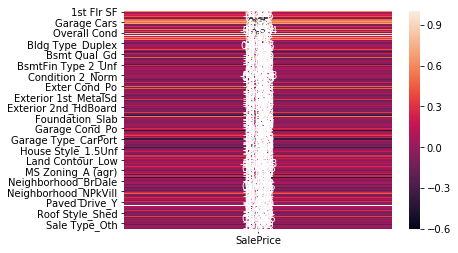

In [97]:
#Just too many variables to make a heatmap useful, but it's pretty so I'll keep it here.
sns.heatmap(train.corr()[['SalePrice']], annot=True)

In [6]:
train.corr()[['SalePrice']].abs().sort_values('SalePrice', ascending=False).head(20)

,SalePrice
SalePrice,1.000000
Overall Qual,0.800207
Gr Liv Area,0.697038
Garage Area,0.650247
Garage Cars,0.648128
Total Bsmt SF,0.628677
1st Flr SF,0.618486
Exter Qual_TA,0.600362
Bsmt Qual_Ex,0.586497
Year Built,0.571849


In [7]:
features = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars','Total Bsmt SF', '1st Flr SF',
           'Exter Qual_TA', 'Bsmt Qual_Ex', 'Year Built', 'Kitchen Qual_Ex', 'Year Remod/Add', 'Kitchen Qual_TA',
           'Full Bath','Foundation_PConc', 'Garage Yr Blt', 'Mas Vnr Area', 'TotRms AbvGrd']
X = train[features]
y = train['SalePrice']

In [8]:
#creating a holdout set from the train dataset. Doing this because we have a "true" test set that is separate
#from the training set.
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state = 42)

In [9]:
ss = StandardScaler()
ss.fit(X)
X_train_scaled = ss.transform(X)
X_holdout_scaled = ss.transform(X_holdout)

Cross valuation score before fitting to the model is .82. So at baseline I am predicting about 82% of the variance of the target Sale Price. 

In [12]:
lm = linear_model.LinearRegression()

In [13]:
cross_val_score(lm, X_train_scaled, y).mean()

0.8199583924036181

In [14]:
model = lm.fit(X_train_scaled, y)
model_score = lm.score(X_train_scaled, y)
model_score

0.8322728157360257

My R-squared on the train set is .89, a small improvement. 

In [16]:
#The r-squared went up just a bit on the holdout set.
model = lm.fit(X_holdout_scaled, y_holdout)
model_score = lm.score(X_holdout_scaled, y_holdout)
model_score

0.8939836061616698

## Model 2: Lasso Regression model with all variables

In this model, I use a Lasso regularization using all the variables. Lasso will penalize the variables with the lowest alpha coefficients, and since there are a great many variables, this technique seemed appropriate. This model has an r-squared score of .96 on the holdout set - which is really good! 

In [23]:
y2 = train['SalePrice']
features2 = [col for col in train.columns if col != 'SalePrice' and col != 'EncodedSaleCondition'] 
# use every column other than the y
X2 = train[features2]

In [24]:
X2_train, X2_holdout, y2_train, y2_holdout = train_test_split(X2, y2, random_state = 42, test_size = 0.3)

In [25]:
ss = StandardScaler()
ss.fit(X2)
X2_train_scaled = ss.transform(X2)
X2_holdout_scaled = ss.transform(X2_holdout)

In [26]:
model = lm.fit(X2_train_scaled, y2)
model_score = lm.score(X2_train_scaled, y2)
model_score

0.9316012084297831

In [102]:
model = lm.fit(X2_train_scaled, y2)
model_score = lm.score(X2_holdout_scaled, y2_holdout)
model_score

0.9425664291816575

Here, Lasso identifies the best alpha to apply to the regression and gives the best score. 

In [106]:
l_alphas = np.arange(.001, .15, .50) #starts at .001, skips .0025, ends at .15
coefs = []
for alpha in l_alphas:
    model = Lasso(alpha = alpha)
    model.fit(X2_train_scaled, y2)
    coefs.append(model.coef_)

/Users/Morgan2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [105]:
best_lasso.score(X2_holdout_scaled, y2_holdout)

0.9630475829484875

It looks like Lasso assigns the highest coefficients to features related to square feet, not surprisingly, as well as Year Built, Overall Quality. These variables make intuitive sense for being related to housing price. 

In [100]:
# best_lasso = LassoCV(alphas = l_alphas)
# best_lasso.fit(X2_holdout_scaled, y2_holdout)
# print('best_alpha', best_lasso.alpha_)

In [33]:
coef_df = pd.DataFrame(model.coef_, columns = ['coef'])
coef_df['features5'] = features2
coef_df.sort_values(by=['coef'],ascending=False).head(10)

,coef,features5
1,26387.909590,2nd Flr SF
0,20195.183797,1st Flr SF
7,16393.930966,BsmtFin SF 1
28,9212.964818,Overall Qual
35,8462.423997,Year Built
6,8455.736387,Bsmt Unf SF
68,8398.409321,BsmtFin Type 2_Unf
38,6159.689286,Bldg Type_1Fam
187,6026.886406,Kitchen Qual_Ex
27,5913.517258,Overall Cond


## Model 3: Model Stacking

In this section, I stack several different regression models to predict house sale price. The key to model stacking is to reduce the correlation between each model, so that each model can contribute a unique amount to the overall prediction. 

In [157]:
y3 = train['SalePrice']
features3 = [col for col in train.columns if col != 'SalePrice' and col != 'EncodedSaleCondition'] 
X3 = train[features3]

In [158]:
X3_train, X3_holdout, y3_train, y3_holdout = train_test_split(X3, y3, random_state = 42)

I create pipelines for each model in which I standardize the variables if needed. I also try to use Principle Components Analysis to for some to try to reduce correlations between each model. 

In [159]:
rf = RandomForestRegressor()

rf_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components=1)),
    ('rf', rf)
])

In [160]:
lr = LinearRegression()

lr_pipe = Pipeline([
     ('ss', StandardScaler()),
    ('pca', PCA(n_components=3)),
])

In [161]:
lasso = Lasso()

lasso_pipe = Pipeline([
    ('pca', PCA(n_components=5)),
    ('ss', StandardScaler()),
    ('lasso', lasso)
])

In [162]:
tree = DecisionTreeRegressor()

In [163]:
knn = KNeighborsRegressor()
knn_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', knn)
])

In [164]:
#ada = AdaBoostRegressor()

In [175]:
models = [
    ('lr', lr),
    ('ridge', ridge_pipe),
    ('tree', tree),
    ('knn', knn_pipe),
    ('ada', ada)
]

This for-loop takes each model and calculates the prediction from each in the train dataset and puts that in a dataframe for comparison. 

In [178]:
predictions_train = pd.DataFrame()
for model_tup in models:
    name, model = model_tup
    predictions_train[name + '_pred'] = cross_val_predict(model, X3_train, y3_train)
    model.fit(X3_train, y3_train)
    
predictions_train.head()

,lr_pred,ridge_pred,tree_pred,knn_pred,ada_pred
0,201158.245979,160306.097333,180000.0,130540.0,186679.438272
1,207823.162079,167280.814967,190000.0,144280.0,216798.088889
2,132052.899936,130350.112420,126500.0,128880.0,121680.367470
3,279136.011669,249569.883048,244000.0,229900.0,229912.870056
4,303797.810251,265743.157911,290000.0,288900.0,309607.844371


Need to try to get our different models as uncorrelated as possible. 

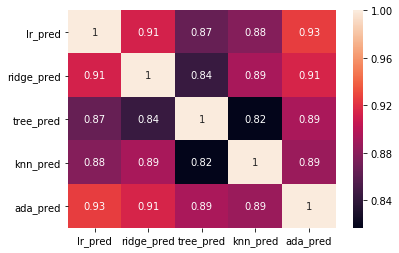

In [179]:
sns.heatmap(predictions_train.corr(), annot=True)

In [180]:
gb_agg = GradientBoostingRegressor()
gb_agg_params = {}
gs = GridSearchCV(gb_agg, param_grid=gb_agg_params)

In [181]:
cross_val_score(gs, predictions_train, y3_train).mean()

0.8641224680947639

In [182]:
gs.fit(predictions_train, y3_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

This part puts the predictions of each model in the test set together in one dataframe.

In [183]:
predictions_test = pd.DataFrame()
for model_tup in models:
    name, model = model_tup
    predictions_test[name + '_pred'] = model.predict(X3_holdout)
    
predictions_test.head()

,lr_pred,ridge_pred,tree_pred,knn_pred,ada_pred
0,130080.035142,123900.743584,138500.0,149679.0,130116.531568
1,217422.595746,195273.166210,237000.0,178760.0,236329.636842
2,318052.353036,283616.877481,254900.0,304000.0,296433.405765
3,122106.040407,126117.325485,149000.0,124200.0,140352.478261
4,199633.441119,245168.523396,196000.0,178970.8,198588.914894


In [184]:
gs.score(predictions_test, y3_holdout)

0.9202035994557077